In [14]:
import scipy
from scipy.linalg import inv
from scipy.spatial import cKDTree
from scipy.stats import stats
import os.path
import fitsio
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.interpolate as inter
from scipy.stats import binned_statistic
from scipy import optimize, ndimage
from scipy.ndimage.filters import gaussian_filter
from zypy.zyutil import getFrames, getColors, figure_handler
from sloanlss import Jackknife_Mesh
from sloanlss import read_arch_skyobj, Arch
from sloanlss import read_lowz_skyobj, LOWZ
from corsky.sample import SkyObjects
from zypy.zycosmo import FRW, CosmoParams
from corsky.correlation import Correlation
import cPickle as pickle
from scatter_contour import scatter_contour
import copy
%matplotlib inline

rootdir = "smem_output/"
datdir = os.path.expanduser("~/Data/redmapper/")
clscat = os.path.join(datdir, "redmapper_dr8_public_v5.10_catalog.fits")
memcat = os.path.join(datdir, "redmapper_dr8_public_v5.10_members.fits")
rmemdat = os.path.join(datdir, "redmapper_dr8_public_v5.10_Rmem_suhurdtest.h5")


In [2]:
Rmem_names = {
        1:  'Psuh+Rsuh',       # Surhud's Rmem_M16
        2:  'Psuh>0.8+Rsuh',   # Surhud's Rmem_Zu
        3:  'Pmem+Rori',       # Ying's Rmem_M16
        4:  'Peff>0.8+Rori',   # Ying's Rmem_Zu
        }

In [3]:
def generate_Rmem_suhurd(rmemdat_to_save=None):
    # zypy.zycosmo is my own cosmology package
    h = 0.7
    cosmo = CosmoParams(omega_M_0=0.27, n=0.96, sigma_8=0.8, h=h, set_flat=True)
    frw = FRW(cosmo=cosmo)
    # cluster catalog
    clstbl = fitsio.FITS(clscat, 'r')[1]
    clsid_arr0 = clstbl["ID"][:]
    lambda_arr0 = clstbl["LAMBDA"][:]
    scale_arr0 = clstbl["S"][:]
    ra_arr0 = clstbl["ra"][:]
    dec_arr0 = clstbl["dec"][:]
    z_arr0 = clstbl["Z_LAMBDA"][:]
    zspec_arr0 = clstbl["Z_SPEC"][:]
    # membership catalog
    memtbl = fitsio.FITS(memcat, 'r')[1]
    clsid_arr1 = memtbl["ID"][:]
    R_arr = memtbl["R"][:]
    ra_arr1 = memtbl["ra"][:]
    dec_arr1 = memtbl["dec"][:]
    #
    P_mem = memtbl["P"][:]
    # probability that the galaxy is not a member of any other clusters
    P_free = memtbl["P_FREE"][:]
    # theta_r and theta_i are basically the radial and magnitude cuts,
    # only implemented with a soft cut rather than a sharp step-function.
    theta_i = memtbl["THETA_I"][:]
    theta_r = memtbl["THETA_R"][:]
    # P_mem_eff
    P_mem_eff = P_mem * P_free * theta_i * theta_r
    # P_mem_eff_suhurd
    P_mem_suhurd = P_mem * P_free
    ncls = clsid_arr0.size
    Rmem_arr1 = np.zeros(ncls)
    Rmem_arr2 = np.zeros(ncls)
    Rmem_arr3 = np.zeros(ncls)
    Rmem_arr4 = np.zeros(ncls)
    # reconstructed richness
    lambda_arr1 = np.zeros(ncls)
    lambda_arr2 = np.zeros(ncls)
    lambda_arr3 = np.zeros(ncls)
    lambda_arr4 = np.zeros(ncls)
    for i, clsid0 in enumerate(clsid_arr0):
        if np.mod(i, 1000) == 0:
            print i
        _idx = (clsid_arr1 == clsid0)
        # use P_mem_suhurd and R computed from scratch, suhurd's version of M16
        _P_mem = P_mem_suhurd[_idx]
        _R_arr = get_R_arr_from_scratch(frw.angular_diameter_distance(z_arr0[i]),
                ra_arr0[i], dec_arr0[i], ra_arr1[_idx], dec_arr1[_idx]) * h
        Rmem_arr1[i] = np.sum(_P_mem * _R_arr) / np.sum(_P_mem)
        lambda_arr1[i] = np.sum(_P_mem) * scale_arr0[i]
        # TESTED, the one below is the eqiuvalent to the one above.
        # _R_arr_suhurd = get_R_arr_from_suhurd(frw.angular_diameter_distance(z_arr0[i]),
                # ra_arr0[i], dec_arr0[i], ra_arr1[_idx], dec_arr1[_idx]) * h
        # Suhurd's Rmem_Zu
        _P_mem = P_mem_suhurd[_idx]
        _sel = (_P_mem >= 0.8)
        if np.sum(_sel) == 0:
            Rmem_arr2[i] = -1.0
            lambda_arr2[i] = -1.0
        else:
            _P_mem = _P_mem[_sel]
            Rmem_arr2[i] = np.sum(_P_mem * _R_arr[_sel]) / np.sum(_P_mem)
            lambda_arr2[i] = np.sum(_P_mem) * scale_arr0[i]
        # Ying's version of M16
        Rmem_arr3[i] = np.sum(P_mem[_idx] * R_arr[_idx]) / np.sum(P_mem[_idx])
        lambda_arr3[i] = np.sum(P_mem[_idx]) * scale_arr0[i]
        # Ying's Rmem_Zu
        _P_mem = P_mem_eff[_idx]
        _sel = (_P_mem >= 0.8)
        if np.sum(_sel) == 0:
            Rmem_arr4[i] = -1.0
            lambda_arr4[i] = -1.0
        else:
            _P_mem = P_mem[_idx][_sel] * P_free[_idx][_sel]
            Rmem_arr4[i] = np.sum(_P_mem * R_arr[_idx][_sel]) / np.sum(_P_mem)
            lambda_arr4[i] = np.sum(_P_mem) * scale_arr0[i]
    if rmemdat_to_save:
        f = h5py.File(rmemdat_to_save, "w")
        f.create_dataset("clsid", data=clsid_arr0)
        f.create_dataset("lambda", data=lambda_arr0)
        f.create_dataset("z", data=z_arr0)
        f.create_dataset("z_spec", data=zspec_arr0)
        f.create_dataset("scale", data=scale_arr0)
        g = f.create_group("Rmem")
        g.create_dataset("Rmem1", data=Rmem_arr1)
        g.create_dataset("Rmem2", data=Rmem_arr2)
        g.create_dataset("Rmem3", data=Rmem_arr3)
        g.create_dataset("Rmem4", data=Rmem_arr4)
        g = f.create_group("LAMBDA")
        g.create_dataset("LAMBDA1", data=lambda_arr1)
        g.create_dataset("LAMBDA2", data=lambda_arr2)
        g.create_dataset("LAMBDA3", data=lambda_arr3)
        g.create_dataset("LAMBDA4", data=lambda_arr4)
        f.close()


In [5]:
def get_R_arr_from_scratch(DA, ra, dec, ra_arr, dec_arr):
    """ recompute the r_arr from  scratch.
    """
    f = np.pi/180.
    cosarr = np.sin(dec*f)*np.sin(dec_arr*f) + np.cos(dec*f)*np.cos(dec_arr*f)*np.cos((ra-ra_arr)*f)
    cosarr[cosarr>1.0] = 0.999999999999
    cosarr[cosarr<-1.0] = -0.99999999999
    ang = np.arccos(cosarr)
    return(ang * DA)

In [6]:
def get_R_arr_from_suhurd(DA, ra, dec, ra_mem, dec_mem):
    """ recompute the r_arr from using suhurd's code.
    """
    f = np.pi/180.
    # Convert into vector on the unit sphere
    xx_cen = np.cos(dec*f) * np.cos(ra*f)
    yy_cen = np.cos(dec*f) * np.sin(ra*f)
    zz_cen = np.sin(dec*f)
    # Convert members into vector on the unit sphere
    xx_mem = np.cos(dec_mem*f) * np.cos(ra_mem*f)
    yy_mem = np.cos(dec_mem*f) * np.sin(ra_mem*f)
    zz_mem = np.sin(dec_mem*f)
    cosang = xx_cen*xx_mem + yy_cen*yy_mem + zz_cen*zz_mem
    cosang[cosang>1.0] = 0.999999999999
    cosang[cosang<-1.0] = -0.99999999999
    angle = np.arccos(cosang)
    # Compute the projected separation
    Rp = angle * DA
    return(Rp)

In [7]:
# catalog making from scratch.
# generate_Rmem_suhurd(rmemdat_to_save=rmemdat)
generate_Rmem_suhurd(rmemdat_to_save=None)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000


In [9]:
def get_Rmem_corrcoeff(Rmem_type0, Rmem_type1, zmin=0.10, zmax=0.50, dz=0.04,
        use_res=True, use_spec=False):
    # they share the same z
    clsid_arr, rmem0_arr, lameff0_arr, lambda_arr, z, zspec, scale_arr = \
            read_Rmem_suhurd(Rmem_type=Rmem_type0, return_metadata=True)
    clsid_arr, rmem1_arr, lameff1_arr, lambda_arr, z, zspec, scale_arr = \
            read_Rmem_suhurd(Rmem_type=Rmem_type1, return_metadata=True)
    z_bins = np.arange(zmin, zmax, dz)
    z_cens = 0.5*(z_bins[1:] + z_bins[:-1])
    rho_arr = np.zeros(z_cens.size)
    for i in xrange(z_cens.size):
        sel = (z >= z_bins[i]) & (z < z_bins[i+1])
        _s0 = rmem0_arr[sel]
        _s1 = rmem1_arr[sel]
        rho, pval = stats.spearmanr(_s0, _s1)
        rho_arr[i] = rho
    if False:
        plt.plot(z_cens, rho_arr, marker='o', color='r', ms=8)
        plt.show()
    return(z_cens, rho_arr)

In [10]:
def get_Rmem_corrcoeff_full(Rmem_type0=1, zmin=0.1, zmax=0.5, dz=0.02,
        figout=None, figext=None, **kwparams):
    fig, axes = getFrames(nframe=1, wid=8, x0=0.10, x1=1, y0=0.02)[:2]
    ax = axes[0]
    types = [1, 2, 3, 4]
    colors = getColors(len(types))
    for i, Rmem_type1 in enumerate(types):
        if Rmem_type1 == Rmem_type0:
            continue
        # label = str(Rmem_type0) + "x" + str(Rmem_type1)
        label = Rmem_names[Rmem_type0] + " x " + Rmem_names[Rmem_type1]
        z, rho = get_Rmem_corrcoeff(Rmem_type0, Rmem_type1, zmin=zmin,
                zmax=zmax, dz=dz, **kwparams)
        ax.plot(z, rho, marker='o', color=colors[i], ms=8, label=label, alpha=0.5)
    ax.axhline(1, color='k', linestyle='dashed')
    ax.vlines(0.33, 0, 1.2, color='k', linestyle='dashed')
    ax.legend(loc=3)
    ax.set_xlim(zmin, zmax+4*dz)
    ax.set_ylim(0., 1.2)
    ax.set_xlabel(r"$z$", fontsize=20)
    ax.set_ylabel(r"$\rho$", fontsize=20)
    figure_handler(fig, figout, figext)

In [12]:
def read_Rmem_suhurd(Rmem_type=1, return_metadata=False):
    """ create the Rmem file.
    """
    f = h5py.File(rmemdat, 'r')
    clsid_arr = f["clsid"][:]
    if return_metadata:
        lambda_arr = f["lambda"][:]
        z_arr = f["z"][:]
        zspec_arr = f["z_spec"][:]
        scale_arr = f["scale"][:]
    Rmem_name = "Rmem" + str(Rmem_type)
    lam_name = "LAMBDA" + str(Rmem_type)
    rmem_arr = f["Rmem/"+Rmem_name][:]
    lameff_arr = f["LAMBDA/"+lam_name][:]
    f.close()
    if return_metadata:
        return(clsid_arr, rmem_arr, lameff_arr,
                lambda_arr, z_arr, zspec_arr, scale_arr)
    else:
        return(clsid_arr, rmem_arr, lameff_arr)

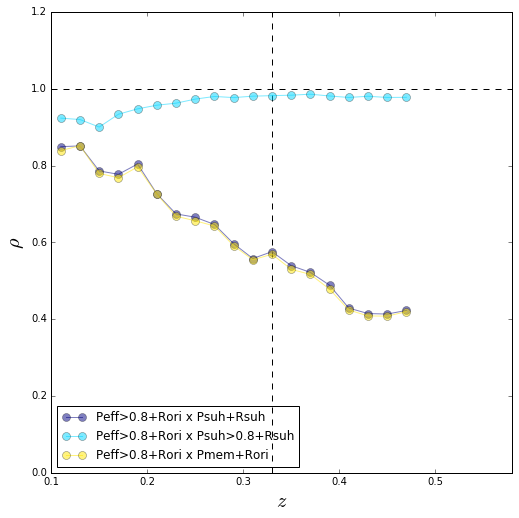

In [15]:
# spearman cross-correlation between different Rmem estimators.
figext = None
get_Rmem_corrcoeff_full(Rmem_type0=4, zmin=0.1, zmax=0.5, dz=0.02, figout='spearman_estimators', figext=figext)

In [8]:
def get_subsamples_spline(Rmem_type, zmin=0.10, zmax=0.50, richmin=20.0,
        richmax=100.0, nzbin=15, nrichbin=15, save_smem=False,
        use_richeff=False, set_showsplit=False, north_only=False,
        figout=None, figext=None):
    clsid_arr, Rmem_arr, richeff = read_Rmem_suhurd(Rmem_type)
    clsid_arr = clsid_arr.astype(int)
    #
    clstbl = fitsio.FITS(clscat, 'r')[1]
    clsid = clstbl["ID"][:]
    if use_richeff:
        rich = richeff
    else:
        rich = clstbl["LAMBDA"][:]
    z = clstbl["Z_LAMBDA"][:]
    z_spec = clstbl["Z_SPEC"][:]
    RA = clstbl["RA"][:]
    DEC = clstbl["DEC"][:]
    # selecting clusters
    if north_only:
        sel = (rich > richmin) & (rich < richmax) & (z >= zmin) & (z <= zmax) \
                & (RA > 100.0) & (RA < 250.0)
    else:
        sel = (rich > richmin) & (rich < richmax) & (z >= zmin) & (z <= zmax)
    clsid = clsid[sel]
    rich = rich[sel]
    z = z[sel]
    z_spec = z_spec[sel]
    RA = RA[sel]
    DEC = DEC[sel]
    # we do not need clsid for this.
    Rmem = Rmem_arr[sel]
    clsflag = np.zeros(clsid.size)
    #
    zbins = np.linspace(zmin, zmax, nzbin)
    zcens = (zbins[1:] + zbins[:-1])/2.
    richbins = np.linspace(richmin, richmax, nrichbin)
    richbins_dense = np.logspace(np.log10(richmin), np.log10(richmax),
            nrichbin*3)
    nlarge = 0
    nsmall = 0
    # +2 for fitting parameters
    if set_showsplit:
        nframe = (nzbin - 1) + 2
    else:
        nframe = (nzbin - 1)
    fig, axes = getFrames(nframe=nframe, ncol=4, wid=12, aspectratio="3x2",
            xgut=0, ygut=0)[:2]
    u_arr = np.zeros(zbins.size-1)
    amp_arr = np.zeros(zbins.size-1)
    err_u_arr = np.zeros(zbins.size-1)
    err_amp_arr = np.zeros(zbins.size-1)
    for i in xrange(zbins.size - 1):
        z0 = zbins[i]
        z1 = zbins[i+1]
        _zsel = (z0 <= z) & (z < z1)
        _zidx = np.where((z0 <= z) & (z < z1))[0]
        _Rmem = Rmem[_zsel]
        _rich = rich[_zsel]
        _rich_avg = np.zeros(richbins.size - 1)
        _Rmem_med = np.zeros(richbins.size - 1)
        _Rmem_sca = np.zeros(richbins.size - 1)
        # error on the mean
        _Rmem_med_err = np.zeros(richbins.size - 1)
        for j in xrange(richbins.size - 1):
            rich0 = richbins[j]
            rich1 = richbins[j+1]
            _richsel = (rich0 <= _rich) & (_rich < rich1) & (_Rmem > 0)
            if np.sum(_richsel) > 4:
                _rich_avg[j] = np.mean(_rich[_richsel])
                _Rmem_med[j] = np.median(_Rmem[_richsel])
                _Rmem_sca[j] = np.std(_Rmem[_richsel])
                _Rmem_med_err[j] = _Rmem_sca[j]/np.sqrt(np.sum(_richsel)*1.)
        _nonzero = (_Rmem_med > 0.0) & (_Rmem_med_err > 0.0)
        _rich_avg = _rich_avg[_nonzero]
        _Rmem_med = _Rmem_med[_nonzero]
        _Rmem_sca = _Rmem_sca[_nonzero]
        _Rmem_med_err = _Rmem_med_err[_nonzero]
        # just a powerlaw fit
        # convert to <rmem> = a * lambda^b
        # http://scipy-cookbook.readthedocs.org/items/FittingData.html
        logx = np.log10(_rich_avg)
        logy = np.log10(_Rmem_med)
        logyerr = _Rmem_med_err / _Rmem_med
        fitfunc = lambda p, x: p[0] + p[1] * x
        errfunc = lambda p, x, y, err: (y - fitfunc(p, x)) / err
        pinit = [np.log10(0.15), 0.25]
        out = optimize.leastsq(errfunc, pinit, args=(logx, logy, logyerr),
                full_output=1)
        pfinal = out[0]
        covar = out[1]
        u = pfinal[1]
        amp = 10.0**pfinal[0]
        err_u = np.sqrt(covar[0][0])
        err_amp = np.sqrt(covar[1][1]) * amp
        u_arr[i] = u
        amp_arr[i] = amp
        err_u_arr[i] = err_u
        err_amp_arr[i] = err_amp
        _s = lambda x: amp * x**u
        # splinefit thru
        # _s = inter.UnivariateSpline(_rich_avg, _Rmem_med, s=5e10)
        ###
        _Rmem_div = _s(_rich)
        _largeR = _Rmem >= _Rmem_div
        nlarge += np.sum(_largeR)
        _smallR = _Rmem < _Rmem_div
        nsmall += np.sum(_smallR)
        # print "#####"
        # print  np.mean(_Rmem[_largeR]) / np.mean(_Rmem[_smallR])
        #
        clsflag[_zidx[_largeR]] = +1
        clsflag[_zidx[_smallR]] = -1
        #
        if set_showsplit:
            axes[i].scatter(_rich[_largeR],
                    _Rmem[_largeR]/(_rich[_largeR])**u/amp, marker="o", s=6,
                    color="cyan", alpha=0.8)
            axes[i].scatter(_rich[_smallR],
                    _Rmem[_smallR]/(_rich[_smallR])**u/amp, marker="o", s=6,
                    color="magenta", alpha=0.8)
            axes[i].plot(richbins_dense,
                    _s(richbins_dense)/richbins_dense**u/amp, 'r--')
            axes[i].errorbar(_rich_avg, _Rmem_med/_rich_avg**u/amp,
                    yerr=_Rmem_med_err/_rich_avg**u, marker="o", ls="None",
                    ecolor="red", mfc="red", mec="red", alpha=0.6)
            axes[i].plot(_rich_avg, 1+(_Rmem_sca)/_rich_avg**u/amp, "g:")
            axes[i].plot(_rich_avg, 1-(_Rmem_sca)/_rich_avg**u/amp, "g:")
            yname = r"$\langle \tilde{R}_{\mathrm{mem}} \rangle$"
            xname = r"$\lambda$"
            fmem = np.mean(_Rmem/_rich**u/amp)
            axes[i].axhline(fmem, color="blue", linestyle="dashed")
            axes[i].set_xlim(richmin, richmax)
            axes[i].set_ylim(0.5, 1.5)
            axes[i].annotate('-'.join([format(z0, '4.3f'), format(z1, '4.3f')]),
                xy=(0.65, 0.9), xycoords="axes fraction")
            if i < 8:
                axes[i].set_xticklabels([])
            else:
                axes[i].set_xlabel(xname)
            if np.mod(i, 4) > 0:
                axes[i].set_yticklabels([])
            else:
                axes[i].set_ylabel(yname)
    if True:
        f_u = inter.UnivariateSpline(zcens, u_arr, s=5e10)
        f_amp = inter.UnivariateSpline(zcens, amp_arr, s=5e10)
    if set_showsplit:
        axes[-2].errorbar(zcens, u_arr, yerr=err_u_arr, marker="o", color="k",
                ls='None')
        axes[-1].errorbar(zcens, amp_arr, yerr=err_amp_arr, marker="o",
                color="k", ls='None')
        zcens_dense = np.arange(0.08, 0.55, 0.01)
        axes[-2].plot(zcens_dense, f_u(zcens_dense), "k-")
        axes[-1].plot(zcens_dense, f_amp(zcens_dense), "k-")
        axes[-2].annotate("slope " + str(Rmem_type), xy=(0.05, 0.9),
                xycoords="axes fraction")
        axes[-1].annotate("amp " + str(Rmem_type), xy=(0.05, 0.9),
                xycoords="axes fraction")
        for i in xrange(zbins.size-1):
            _ubar = f_u(zcens[i])
            _ampbar = f_amp(zcens[i])
            _dsbar = lambda x: _ampbar * x**(_ubar-u_arr[i])/amp_arr[i]
            axes[i].plot(richbins_dense, _dsbar(richbins_dense), color="k",
                    ls="--", lw=2)
        figure_handler(fig, figout, figext)
    print nlarge,
    print nsmall
    if save_smem:
        # XXX WE ARE RE-READING EVERYING HERE
        # we want the smem data to be independent
        # Rmem/(rich**f_u(z))/f_amp(z)
        clsid_arr, Rmem_arr, richeff = read_Rmem_suhurd(Rmem_type)
        clstbl = fitsio.FITS(clscat, 'r')[1]
        RA = clstbl["RA"][:]
        DEC = clstbl["DEC"][:]
        rich = clstbl["LAMBDA"][:]
        z = clstbl["Z_LAMBDA"][:]
        z_spec = clstbl["Z_SPEC"][:]
        # always create new file
        if north_only:
            smemdat = os.path.join(datdir,
                    "redmapper_dr8_public_v5.10_smem_spline"+str(Rmem_type)+"_nc.h5")
        else:
            smemdat = os.path.join(datdir,
                    "redmapper_dr8_public_v5.10_smem_spline"+str(Rmem_type)+".h5")
        smem = Rmem_arr/(rich**f_u(z))/f_amp(z)
        # XXX this is sketchy, make those with Rmem=-1/0 to have smem of 1
        smem[smem<=0.0] = 1.0
        # calibrate scatter
        if True:
            # this is where we calibrate everying
            # sel = (rich > richmin) & (rich < richmax) & (z >= zmin) &
            # (z <= zmax)
            # only control for z here as richness outside of normal range won't
            # hurt here
            if north_only:
                sel = (z >= zmin) & (z <= zmax) & (RA > 100.0) & (RA < 250.0)
            else:
                sel = (z >= zmin) & (z <= zmax)
            rich_bins = np.linspace(20, richmax, 10)
            rich_cens = 0.5*(rich_bins[1:] + rich_bins[:-1])
            sca_arr = np.zeros(rich_cens.size)
            for i in xrange(rich_bins.size - 1):
                _sel = (rich >= rich_bins[i]) & (rich < rich_bins[i+1])
                this = sel & _sel
                sca = np.std(smem[this])
                sca_arr[i] = sca
            _f_sca = inter.UnivariateSpline(rich_cens, sca_arr, s=5e10)

            def f_sca(r):
                # stop ridiculous spline interp
                t = np.empty_like(r)
                t[r<=richmax] = _f_sca(r[r<=richmax])
                t[r>richmax] = _f_sca(richmax)
                return(t)
            if False:
                plt.plot(rich_cens, sca_arr, marker='o', ls='None', color='r')
                rich_dense = np.arange(20., 300., 1.0)
                plt.plot(rich_dense, f_sca(rich_dense), ls='-', color='k')
                plt.show()
            # scale so that smem has a scatter of 0.15
            _sca = f_sca(rich)
            smem_res = 1.0 + 0.15*(smem-1.0)/_sca
            newsel = (rich > richmin) & (rich < richmax) & (z >= zmin) & (
                    z <= zmax)
            # make sure those we want doesn't have negative values
            print np.min(smem_res[newsel]),
            print np.max(smem_res[newsel])
            print np.median(smem_res[newsel]),
            print np.std(smem_res[newsel])
            if False:
                _sca_arr = np.zeros(rich_cens.size)
                for i in xrange(rich_bins.size - 1):
                    _sel = (rich >= rich_bins[i]) & (rich < rich_bins[i+1])
                    this = sel & _sel
                    sca = np.std(smem_res[this])
                    _sca_arr[i] = sca
                plt.scatter(rich[sel], smem_res[sel], marker=".", c=z[sel],
                        alpha=0.2)
                plt.plot(rich_cens, 1+_sca_arr, marker='+', ls='--', color='r')
                plt.plot(rich_cens, 1-_sca_arr, marker='+', ls='--', color='r')
                plt.xlim(20, 100)
                # plt.ylim(0, 2)
                plt.show()
        if True:
            f = h5py.File(smemdat, "w")
            f.create_dataset("clsid", data=clsid_arr)
            f.create_dataset("RA", data=RA)
            f.create_dataset("DEC", data=DEC)
            f.create_dataset("lambda", data=rich)
            f.create_dataset("lambda_eff", data=richeff)
            f.create_dataset("z", data=z)
            f.create_dataset("z_spec", data=z_spec)
            f.create_dataset("Rmem", data=Rmem_arr)
            f.create_dataset("smem", data=smem)
            f.create_dataset("smem_res", data=smem_res)
            f.close()


In [21]:
def test_smem_spline(figext=None):
    """ my spline split.
    """
    # for Rmem_type in [1, 2, 3, 4]:
    for Rmem_type in [4]:
        if True:
            # show the split
            figout = "plots/subsample_spline_split_"+str(Rmem_type)
            set_showsplit = True
            save_smem = False
        else:
            # save the file with normalized Rmem
            figout = "test"
            set_showsplit = False
            save_smem = True
        get_subsamples_spline(Rmem_type, zmin=0.10, zmax=0.50, richmin=20.0,
                richmax=100.0, nzbin=17, nrichbin=8, use_richeff=False,
                save_smem=save_smem, set_showsplit=set_showsplit,
                north_only=False, figout=figout, figext=figext)

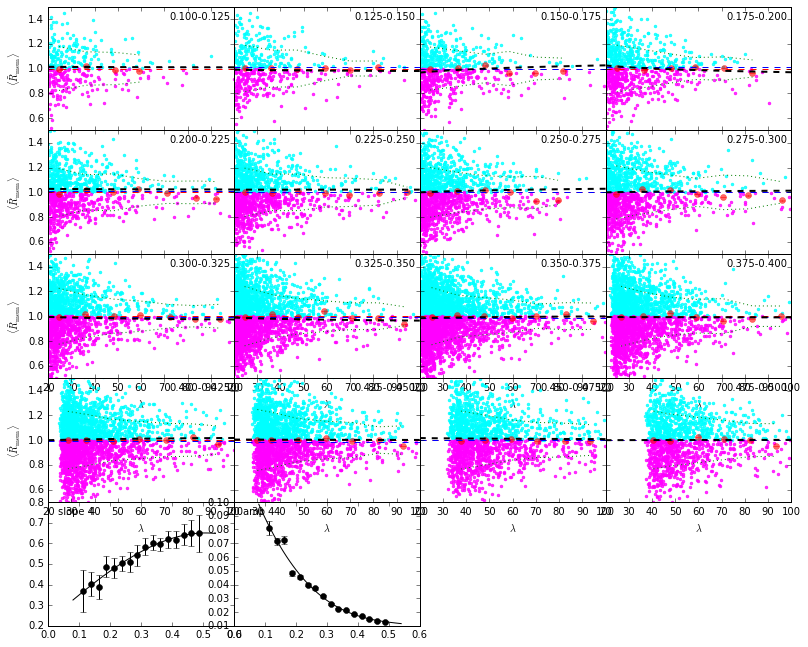

11937 12038


In [22]:
test_smem_spline(figext)

In [23]:
def get_subsamples_discrete(Rmem_type, zmin=0.10, zmax=0.50, richmin=20.0,
        richmax=100.0, nzbin=15, nrichbin=15, save_smem=False, znum=573,
        use_richeff=False, set_showsplit=False, north_only=False,
        figout=None, figext=None):
    clsid_arr, Rmem_arr, richeff = read_Rmem_suhurd(Rmem_type)
    clsid_arr = clsid_arr.astype(int)
    #
    clstbl = fitsio.FITS(clscat, 'r')[1]
    clsid = clstbl["ID"][:]
    if use_richeff:
        rich = richeff
    else:
        rich = clstbl["LAMBDA"][:]
    z = clstbl["Z_LAMBDA"][:]
    z_spec = clstbl["Z_SPEC"][:]
    RA = clstbl["RA"][:]
    DEC = clstbl["DEC"][:]
    # selecting clusters
    if north_only:
        sel = (rich > richmin) & (rich < richmax) & (z >= zmin) & (z <= zmax) \
                & (RA > 100.0) & (RA < 250.0)
    else:
        sel = (rich > richmin) & (rich < richmax) & (z >= zmin) & (z <= zmax)
    nsel = np.sum(sel)
    clsid = clsid[sel]
    rich = rich[sel]
    z = z[sel]
    z_spec = z_spec[sel]
    RA = RA[sel]
    DEC = DEC[sel]
    # we do not need clsid for this.
    Rmem = Rmem_arr[sel]
    #
    up = (Rmem==Rmem)
    down = (Rmem==Rmem)
    clsflag = np.zeros(clsid.size)
    # follow suhurd's way
    zarray = np.sort(z)
    if znum is None:
        znum = nsel / nzbin
    else:
        nzbin = nsel / znum
    smem = Rmem*0.0
    smem_res = Rmem*0.0
    if set_showsplit:
        nframe = nzbin
        fig, axes = getFrames(nframe=nframe, ncol=4, wid=12, aspectratio="3x2",
                xgut=0, ygut=0)[:2]
    rich_bins = np.linspace(20, richmax, 10)
    rich_cens = 0.5*(rich_bins[1:] + rich_bins[:-1])
    nlarge= 0
    nsmall= 0
    for i in xrange(nzbin):
        _zmin = zarray[i*znum]
        if i != nzbin-1:
            _zmax = zarray[(i+1)*znum]
        else:
            _zmax = zarray[-1]+0.0001
        idx = (z>=_zmin)&(z<_zmax)
        # get medians
        stat, bin_edges, ibin = binned_statistic(np.log10(rich[idx]), Rmem[idx], statistic='median', bins=nrichbin)
        # get means
        meanstat, meanbin_edges, meanibin = binned_statistic(np.log10(rich[idx]), Rmem[idx], statistic='mean', bins=nrichbin)
        ibin[ibin>stat.size] = stat.size
        meanibin[meanibin>meanstat.size] = meanstat.size
        upsub = Rmem[idx]>stat[ibin-1]
        downsub = Rmem[idx]<=stat[ibin-1]
        up[idx] = upsub
        down[idx] = downsub
        smem[idx] = Rmem[idx]/meanstat[meanibin-1]
        # XXX fend against weird numbers, very rare (TESTED)
        smem[idx][smem[idx]<=0.0] = 1.0
        # calibrate scatter
        if True:
            sca_arr = np.zeros(rich_cens.size)
            for j in xrange(rich_bins.size - 1):
                _sel = (rich >= rich_bins[j]) & (rich < rich_bins[j+1])
                this = idx & _sel
                sca = np.std(smem[this])
                sca_arr[j] = sca
            _f_sca = inter.UnivariateSpline(rich_cens, sca_arr, s=5e10)
            def f_sca(r):
                # stop ridiculous spline interp
                t = np.empty_like(r)
                t[r<=richmax] = _f_sca(r[r<=richmax])
                t[r>richmax] = _f_sca(richmax)
                return(t)
            # scale so that smem has a scatter of 0.15
            _sca = f_sca(rich[idx])
            smem_res = 1.0 + 0.15*(smem[idx]-1.0)/_sca
        #
        _Rmem = Rmem[idx]
        _Rmem_div = meanstat[meanibin-1]
        _largeR = _Rmem >= _Rmem_div
        nlarge += np.sum(_largeR)
        _smallR = _Rmem < _Rmem_div
        nsmall += np.sum(_smallR)
        #
        clsflag[idx][_largeR] = +1
        clsflag[idx][_smallR] = -1
        #
        if set_showsplit:
            axes[i].scatter(rich[idx][upsub], Rmem[idx][upsub], s=6, color='cyan', alpha=0.8)
            axes[i].scatter(rich[idx][downsub], Rmem[idx][downsub], s=6, color='magenta', alpha=0.8)
            # axes[i].scatter(rich[idx][upsub], smem[idx][upsub], s=6, color='cyan', alpha=0.8)
            # axes[i].scatter(rich[idx][downsub], smem[idx][downsub], s=6, color='magenta', alpha=0.8)
            yname = r"$\langle \tilde{R}_{\mathrm{mem}} \rangle$"
            xname = r"$\lambda$"
            axes[i].set_xlim(richmin, richmax)
            axes[i].set_ylim(0.1, 0.6)
            axes[i].annotate('-'.join([format(_zmin, '4.3f'), format(_zmax, '4.3f')]),
                xy=(0.65, 0.9), xycoords="axes fraction")
            if i < 8:
                axes[i].set_xticklabels([])
            else:
                axes[i].set_xlabel(xname)
            if np.mod(i, 4) > 0:
                axes[i].set_yticklabels([])
            else:
                axes[i].set_ylabel(yname)
    if set_showsplit:
        figure_handler(fig, figout, figext)
    print nlarge,
    print nsmall
    if save_smem:
        # print np.sum(np.isnan(smem))
        # there could be one or two cases of nan.
        smem[np.isnan(smem)] = 1.0
        # XXX WE ARE NOT RE-READING ANYTHING HERE
        # always create new file
        if north_only:
            smemdat = os.path.join(datdir,
                    "redmapper_dr8_public_v5.10_smem_discrete"+str(Rmem_type)+"_nc.h5")
        else:
            smemdat = os.path.join(datdir,
                    "redmapper_dr8_public_v5.10_smem_discrete"+str(Rmem_type)+".h5")
        if True:
            f = h5py.File(smemdat, "w")
            f.create_dataset("clsid", data=clsid_arr)
            f.create_dataset("RA", data=RA)
            f.create_dataset("DEC", data=DEC)
            f.create_dataset("lambda", data=rich)
            f.create_dataset("lambda_eff", data=richeff)
            f.create_dataset("z", data=z)
            f.create_dataset("z_spec", data=z_spec)
            f.create_dataset("Rmem", data=Rmem_arr)
            f.create_dataset("smem", data=smem)
            f.create_dataset("smem_res", data=smem_res)
            f.close()


In [27]:
def test_smem_discrete(figext=None):
    """ discrete split following Surhud's code.
    """
    # for Rmem_type in [1, 2, 3, 4]:
    for Rmem_type in [4]:
        if True:
            figout = "plots/subsample_discrete_split_"+str(Rmem_type)
            set_showsplit = True
            save_smem = False
        else:
            figout = "test"
            set_showsplit = False
            save_smem = True
        # try to replicate what surhud did, only use clusters up to 0.33
        get_subsamples_discrete(Rmem_type, zmin=0.10, zmax=0.33, richmin=20.0,
                richmax=100.0, nzbin=15, nrichbin=15, save_smem=save_smem, znum=None,
        # extend to higher redshifts.
        # get_subsamples_discrete(Rmem_type, zmin=0.10, zmax=0.55, richmin=20.0,
        #        richmax=100.0, nzbin=45, nrichbin=15, save_smem=save_smem, znum=573,
                use_richeff=False, set_showsplit=set_showsplit, north_only=False,
                figout=figout, figext=figext)

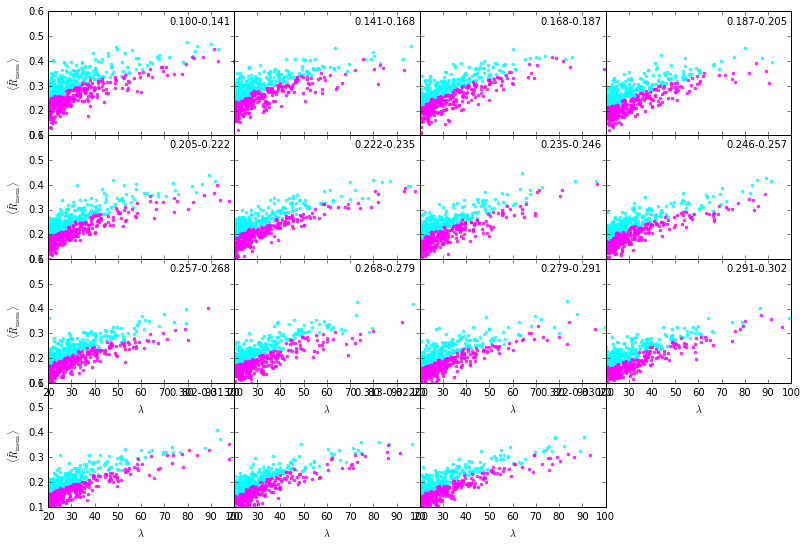

4254 4355


In [28]:
test_smem_discrete(figext)

In [31]:
def cluster_angular_marked_correlation_cmu(Rmem_type, zrange0, zrange1, nabin=15,
        amin_arcmin=10.0, amax_arcmin=200.0, zb1=0.50, mediancut='discrete',
        richmin=20.0, richmax=100.0, north_only=True,
        use_res=True, use_spec=False):
    """ cluster angular correlation function, used by my default calculation.
    """
    ra, dec, z, s, l = read_smem_cat_suhurd_with_lambda(Rmem_type, use_res=use_res,
            use_spec=use_spec, mediancut=mediancut)
    smemstr = "smem" + str(Rmem_type)
    if use_res:
        smemstr += "res"
    if use_spec:
        zclsstr = "spec"
    else:
        zclsstr = "phot"
    outstr = smemstr + "_" + zclsstr
    method = "marked"
    for i, zrange in enumerate([zrange0, zrange1]):
        if i == 0:
            z0, z1 = zrange
            zstr0 = '-'.join([format(z0, '3.2f'), format(z1, '3.2f')])
        else:
            z0, z1 = zrange
            zstr1 = '-'.join([format(z0, '3.2f'), format(z1, '3.2f')])
        if north_only:
            sel = (ra > 100.0) & (ra< 250.0) & (z >= z0) & (z <= z1) & (l >= richmin) & (l <= richmax)
        else:
            sel = (z >= z0) & (z <= z1) & (l >= richmin) & (l <= richmax)
        _ra = ra[sel]
        _dec = dec[sel]
        _s = s[sel]  # will be used as marks
        _s_mean = np.mean(_s)
        # this is to make sure the mean is exactly unity.
        _s = _s/_s_mean
        mesh_type = "mgs100"
        #
        jmesh = Jackknife_Mesh(mesh_type=mesh_type)
        # take care of clusters in the southern sky
        if north_only:
            _jackid = jmesh.get_jackid(_ra, _dec, set_plot=False, figout=None,
                    figext=None, ntest=50000)
        else:
            _jackid = np.zeros(_ra.size, dtype=int)
            _sel = (_ra > 100.0) & (_ra < 250.0)
            _sel1 = _ra <= 100.0
            _sel2 = _ra >= 250.0
            _jackid[_sel] = jmesh.get_jackid(_ra[_sel], _dec[_sel], set_plot=False, figout=None, figext=None, ntest=50000)
            _jackid[_sel1] = 100
            _jackid[_sel2] = 101
        #
        so_c = SkyObjects(ra_deg=_ra, dec_deg=_dec, jackid=_jackid, mark=_s)
        if i == 0:
            so_c0 = so_c
        else:
            so_c1 = so_c
    set_memsaver = False
    corr = Correlation(skyobjdat_p=so_c0, skyobjdat_s=so_c1, ntree_dat_p=1,
            ntree_dat_s=1, set_memsaver=set_memsaver)
    abins = np.logspace(np.log10(amin_arcmin), np.log10(amax_arcmin), nabin) / 60.0
    if True:
        fpickle = rootdir+outstr+"wthetamark_" + mediancut + "_z"+zstr0+"-"+zstr1+".p"
        mrk, jack, thetacens = corr.wtheta(abins, method=method,
                return_err=True, return_bincens=True)
        mrk_jack, err_mrk, covmat_jack = jack
        print mrk_jack
        chi2 = gaussian_chi2(mrk_jack, np.ones(mrk_jack.size), covmat_jack)
        # chi2r = chi2
        chi2r = chi2/(abins.size - 2.)
        # print chi2
        # print np.sum((mrk_jack - 1.)**2/err_mrk**2) /(abins.size - 1.)
        # print chi2/(abins.size - 1.)
        y = err_mrk.repeat(mrk.size).reshape((mrk.size, mrk.size))
        print covmat_jack/(y*y.T)
        result = [abins, mrk_jack, err_mrk, covmat_jack, thetacens]
        # comoving but with h
        print("pickling results to %s" % fpickle)
        pickle.dump(result, open(fpickle, "wb"))
        corr.free_trees()
    return(chi2r)


def cluster_angular_marked_correlation_ipmu(Rmem_type, zrange0, zrange1, nabin=15,
        amin_arcmin=10.0, amax_arcmin=200.0, mediancut='discrete',
        richmin=20.0, richmax=100.0, north_only=True,
        use_res=True, use_spec=False):
    """ cluster angular correlation function
    """
    ra, dec, z, s, l = read_smem_cat_suhurd_with_lambda(Rmem_type, use_res=use_res,
            use_spec=use_spec, mediancut=mediancut)
    smemstr = "smem" + str(Rmem_type)
    if use_res:
        smemstr += "res"
    if use_spec:
        zclsstr = "spec"
    else:
        zclsstr = "phot"
    outstr = smemstr + "_" + zclsstr
    for i, zrange in enumerate([zrange0, zrange1]):
        if i == 0:
            z0, z1 = zrange
            zstr0 = '-'.join([format(z0, '3.2f'), format(z1, '3.2f')])
        else:
            z0, z1 = zrange
            zstr1 = '-'.join([format(z0, '3.2f'), format(z1, '3.2f')])
        if north_only:
            sel = (ra > 100.0) & (ra< 250.0) & (z >= z0) & (z <= z1) & (l >= richmin) & (l <= richmax)
        else:
            sel = (z >= z0) & (z <= z1) & (l >= richmin) & (l <= richmax)
        _ra = ra[sel]
        _dec = dec[sel]
        _z = z[sel]
        _s = s[sel]  # will be used as marks
        # this is to make sure the mean is exactly unity.
        _s_mean = np.mean(_s)
        _s = _s/_s_mean
        if i == 0:
            ra0 = _ra * np.pi / 180.
            dec0 = _dec * np.pi / 180.
            zz0 = _z
            mark0 = _s
        else:
            ra1 = _ra * np.pi / 180.
            dec1 = _dec * np.pi / 180.
            zz1 = _z
            mark1 = _s
    angmin = (amin_arcmin/60.)*np.pi/180.
    angmax = (amax_arcmin/60.)*np.pi/180.
    # original code from Suhurd, with primary-based jackknife covariance
    rrarray, mrk_jack, err_mrk, covmat_jack = get_marked_statistics(ra0, dec0,
            zz0, mark0, ra1, dec1, zz1, mark1, angmin, angmax, nabin)
    thetacens  = rrarray * 180. / np.pi
    if True:
        fpickle = rootdir+outstr+"wthetamark_" + mediancut + "_z"+zstr0+"-"+zstr1+"_ipmu.p"
        chi2 = gaussian_chi2(mrk_jack, np.ones(mrk_jack.size), covmat_jack)
        # dummy variable
        abins = thetacens
        chi2r = chi2/(thetacens.size - 1.)
        result = [abins, mrk_jack, err_mrk, covmat_jack, thetacens]
        # comoving but with h
        print("pickling results to %s" % fpickle)
        pickle.dump(result, open(fpickle, "wb"))
    return(chi2r)


def cluster_angular_marked_correlation_ipmu_modified(Rmem_type, zrange0, zrange1, nabin=15,
        amin_arcmin=10.0, amax_arcmin=200.0, mediancut='discrete',
        north_only=True, richmin=20.0, richmax=100.0, angular=True,
        use_res=True, use_spec=False):
    """ cluster angular correlation function
    """
    # ra, dec, z, s = read_smem_cat_suhurd(Rmem_type, use_res=use_res,
            # use_spec=use_spec, mediancut=mediancut)
    ra, dec, z, s, l = read_smem_cat_suhurd_with_lambda(Rmem_type, use_res=use_res,
            use_spec=use_spec, mediancut=mediancut)
    smemstr = "smem" + str(Rmem_type)
    if use_res:
        smemstr += "res"
    if use_spec:
        zclsstr = "spec"
    else:
        zclsstr = "phot"
    if angular:
        outstr = smemstr + "_" + zclsstr
    else:
        outstr = smemstr + "_" + zclsstr + '_pproj'
    for i, zrange in enumerate([zrange0, zrange1]):
        if i == 0:
            z0, z1 = zrange
            zstr0 = '-'.join([format(z0, '3.2f'), format(z1, '3.2f')])
        else:
            z0, z1 = zrange
            zstr1 = '-'.join([format(z0, '3.2f'), format(z1, '3.2f')])
            oneslice = True
        if north_only:
            sel = (ra > 100.0) & (ra< 250.0) & (z >= z0) & (z <= z1) & (l >= richmin) & (l <= richmax)
        else:
            sel = (z >= z0) & (z <= z1) & (l >= richmin) & (l <= richmax)
        _ra = ra[sel]
        _dec = dec[sel]
        _z = z[sel]
        _s = s[sel]  # will be used as marks
        _s_mean = np.mean(_s)
        # this is to make sure the mean is exactly unity.
        _s = _s/_s_mean
        if i == 0:
            ra0 = _ra * np.pi / 180.
            dec0 = _dec * np.pi / 180.
            zz0 = _z
            mark0 = _s
        else:
            ra1 = _ra * np.pi / 180.
            dec1 = _dec * np.pi / 180.
            zz1 = _z
            mark1 = _s
    #
    if angular:
        angmin = (amin_arcmin/60.)*np.pi/180.
        angmax = (amax_arcmin/60.)*np.pi/180.
    else:
        # projected distances now
        # using amin and amax, and the redshift range of the primary catalog to
        # figure out the corresponding projected distances.
        _angmin = (amin_arcmin/60.)*np.pi/180.
        _angmax = (amax_arcmin/60.)*np.pi/180.
        # XXX the primary is the i == 0 catalog.
        h = 0.7
        cosmo = CosmoParams(omega_M_0=0.27, n=0.96, sigma_8=0.8, h=h, set_flat=True)
        frw = FRW(cosmo=cosmo)
        _zmin = np.min(zz0)
        _zmax = np.max(zz0)
        # using comoving rather than angular diameter here.
        angmin = _angmin * frw.comoving_distance(_zmin) * h
        angmax = _angmax * frw.comoving_distance(_zmax) * h
        print angmin,
        print angmax
        # angmin = 10.
        # angmax = 40.
    rrarray, mrk_jack, err_mrk, covmat_jack = get_marked_statistics_modified(
            ra0, dec0, zz0, mark0, ra1, dec1, zz1, mark1, angmin, angmax, nabin,
            angular=angular)
    #
    if angular:
        thetacens  = rrarray * 180. / np.pi
    else:
        thetacens  = rrarray
    if True:
        fpickle = rootdir+outstr+"wthetamark_" + mediancut + "_z"+zstr0+"-"+zstr1+"_ipmu.p"
        chi2 = gaussian_chi2(mrk_jack, np.ones(mrk_jack.size), covmat_jack)
        # dummy
        abins = thetacens
        chi2r = chi2/(thetacens.size - 1.)
        result = [abins, mrk_jack, err_mrk, covmat_jack, thetacens]
        # comoving but with h
        print("pickling results to %s" % fpickle)
        pickle.dump(result, open(fpickle, "wb"))
    return(chi2r)


def gaussian_chi2(datavec, predvec, errmat):
    # from javelin.cholesky_utils import cholesky, chosolve_from_tri, chodet_from_tri
    _C = errmat
    _b = datavec - predvec
    try:
        _p = np.transpose(_b).dot(inv(_C)).dot(_b)
    except np.linalg.linalg.LinAlgError:
        _U = scipy.linalg.cholesky(_C)
        _x = chosolve_from_tri(_U, _b)
        _p = np.dot(_b, _x)
    return(_p)

In [32]:
def read_Rmem_suhurd(Rmem_type=1, return_metadata=False):
    """ create the Rmem file.
    """
    f = h5py.File(rmemdat, 'r')
    clsid_arr = f["clsid"][:]
    if return_metadata:
        lambda_arr = f["lambda"][:]
        z_arr = f["z"][:]
        zspec_arr = f["z_spec"][:]
        scale_arr = f["scale"][:]
    Rmem_name = "Rmem" + str(Rmem_type)
    lam_name = "LAMBDA" + str(Rmem_type)
    rmem_arr = f["Rmem/"+Rmem_name][:]
    lameff_arr = f["LAMBDA/"+lam_name][:]
    f.close()
    if return_metadata:
        return(clsid_arr, rmem_arr, lameff_arr,
                lambda_arr, z_arr, zspec_arr, scale_arr)
    else:
        return(clsid_arr, rmem_arr, lameff_arr)


def read_smem_cat_suhurd(Rmem_type=1, use_res=True, use_spec=False, mediancut="suhurd"):
    smemdat = os.path.join(datdir,
            "redmapper_dr8_public_v5.10_smem_"+mediancut+str(Rmem_type)+".h5")
    print("reading from %s" % smemdat)
    f = h5py.File(smemdat, 'r')
    clsid = f["clsid"][:]
    ra = f["RA"][:]
    dec = f["DEC"][:]
    lam = f["lambda"][:]
    lam_eff = f["lambda_eff"][:]
    z = f["z"][:]
    z_spec = f["z_spec"][:]
    Rmem = f["Rmem"][:]
    smem = f["smem"][:]
    smem_res = f["smem_res"][:]
    f.close()
    if use_res:
        s = smem_res
    else:
        s = smem
    if use_spec:
        sel = z_spec > 0.0
        return(ra[sel], dec[sel], z[sel], s[sel])
    else:
        return(ra, dec, z, s)


def read_smem_cat_suhurd_with_lambda(Rmem_type=1, use_res=True, use_spec=False, mediancut="discrete"):
    smemdat = os.path.join(datdir,
            "redmapper_dr8_public_v5.10_smem_"+mediancut+str(Rmem_type)+".h5")
    print("reading from %s" % smemdat)
    f = h5py.File(smemdat, 'r')
    clsid = f["clsid"][:]
    ra = f["RA"][:]
    dec = f["DEC"][:]
    lam = f["lambda"][:]
    lam_eff = f["lambda_eff"][:]
    z = f["z"][:]
    z_spec = f["z_spec"][:]
    Rmem = f["Rmem"][:]
    smem = f["smem"][:]
    smem_res = f["smem_res"][:]
    f.close()
    if use_res:
        s = smem_res
    else:
        s = smem
    if use_spec:
        sel = z_spec > 0.0
        return(ra[sel], dec[sel], z[sel], s[sel], lam[sel])
    else:
        return(ra, dec, z, s, lam)


def read_wp(fpickle, h=0.70, skip_nrp=0):
    """ outputs in Mpc/h units
    """
    rpbins, wp_jack, err, cov, rpcens = pickle.load(open(fpickle, "r"))
    rpbins *= h
    wp_jack *= h
    err *= h
    cov *= h**2
    rpcens *= h
    if skip_nrp > 0:
        rpbins = rpbins[skip_nrp:]
        wp_jack = wp_jack[skip_nrp:]
        err = err[skip_nrp:]
        cov = cov[skip_nrp:, skip_nrp:]
        rpcens = rpcens[skip_nrp:]
    return(rpbins, wp_jack, err, cov, rpcens)

In [125]:
def comp_angular_mark(zstrs_list, outstr_list, mediancut='discrete', label_list=None, ymin=0.985, ymax=1.04,
        use_band=False, figout=None, figext=None, z10mpc=None, colors=None, markers=None, lss=None, set_ipmu=False):
    if colors is None:
        colors = getColors(len(zstrs_list))
    if markers is None:
        markers = ['o']*len(zstrs_list)
    if lss is None:
        lss = ['-']*len(zstrs_list)
    fig, axes = getFrames(nframe=1, ncol=1, wid=8, aspectratio="3x2", y0=0.03,
            x0=0.10, x1=1.05)[:2]
    ax0 = axes[0]
    h = 1.0
    if z10mpc is not None:
        frw = FRW()
    if label_list is None:
        label_list = outstr_list
    for i, (zstrs, outstr, label, c, m, ls) in enumerate(
            zip(zstrs_list, outstr_list, label_list, colors, markers, lss)):
        zstr0, zstr1 = zstrs
        if set_ipmu:
            fpickle = rootdir+outstr+"wthetamark_" + mediancut + "_z"+zstr0+"-"+zstr1+"_ipmu.p"
        else:
            fpickle = rootdir+outstr+"wthetamark_" + mediancut + "_z"+zstr0+"-"+zstr1+".p"
        print fpickle
        # everything is angular or pseudo-angular, set h=1 here.
        abins, mrk, err, cov, acens = read_wp(fpickle, h=1.0)
        if 'pproj' not in outstr:
            abins = abins*60.0
            acens = acens*60.0
        if use_band:
            ax0.plot(acens, mrk, color=c, ls=ls, lw=2, marker=m, ms=8,
                    label=label + " [" + zstr0 + ", " + zstr1 + "]", alpha=0.8)
            print c
            ax0.fill_between(acens, mrk+err, mrk-err, color=c, alpha=0.5)
        else:
            ax0.errorbar(acens*1.01**i, mrk, yerr=err, marker=m, ms=8, color=c,
                    ls=ls, label=label+"-"+zstr0+"-"+zstr1, lw=1, alpha=0.7,
                    mfc=c, mec=c)
    ax0.set_ylim(ymin, ymax)
    ax0.legend(loc=1, frameon=True, fontsize=16)
    ax0.axhline(1.0, color="0.1", linestyle="dotted", lw=2)
    # ax0.set_xlim(abins[0], abins[-1])
    if "pproj" in outstr:
        # ax0.set_xlim(10, 200)
        ax0.set_xlim(abins[0]*0.9, abins[-1]*1.1)
        ax0.set_xlabel(r"$R\;[\mathrm{Mpc}/h]$", fontsize=20, labelpad=1)
    else:
        ax0.set_xlim(10, 200)
        ax0.set_xlabel(r"$\theta\;[\mathrm{arcmin}]$", fontsize=20, labelpad=1)
    ax0.set_xscale("log")
    ax0.set_ylabel(r"$M_{R_{mem}}$", fontsize=20)
    figure_handler(fig, figout, figext)


In [37]:
def get_marked_statistics(ra, dec, zred, wt, rra, ddec, zzred, wwt, rmin, rmax,
        rbins, angular=True):
    wwt = wwt/np.average(wwt)
    wt = wt/np.average(wt)
    # print np.average(wt), np.average(wwt)
    # Jack knife requires the ra, dec to be in degrees
    # jack = getregions("Zu_M16_comparison/A-regions_102.list", ra*180./np.pi, dec*180./np.pi)
    # jjack = getregions("Zu_M16_comparison/A-regions_102.list", rra*180./np.pi, ddec*180./np.pi)
    # XXX substitude using my jackid
    mesh_type = "mgs100"
    jmesh = Jackknife_Mesh(mesh_type=mesh_type)
    # take care of clusters in the southern sky
    sel = (ra*180./np.pi > 100.0) & (ra*180./np.pi < 250.0)
    _sel1 = ra*180./np.pi <= 100.0
    _sel2 = ra*180./np.pi >= 250.0
    ssel = (rra*180./np.pi > 100.0) & (rra*180./np.pi < 250.0)
    _ssel1 = rra*180./np.pi <= 100.0
    _ssel2 = rra*180./np.pi >= 250.0
    if np.sum(~sel) == 0:
        jack = jmesh.get_jackid(ra*180./np.pi, dec*180./np.pi, set_plot=False, figout=None, figext=None, ntest=50000)
        jjack = jmesh.get_jackid(rra*180./np.pi, ddec*180./np.pi, set_plot=False, figout=None, figext=None, ntest=50000)
    else:
        jack = np.zeros(ra.size, dtype=int)
        jjack = np.zeros(rra.size, dtype=int)
        jack[sel] = jmesh.get_jackid(ra[sel] *180./np.pi, dec[sel] *180./np.pi, set_plot=False, figout=None, figext=None, ntest=50000)
        jack[_sel1] = 100
        jack[_sel2] = 101
        jjack[ssel] = jmesh.get_jackid(rra[ssel] *180./np.pi, ddec[ssel] *180./np.pi, set_plot=False, figout=None, figext=None, ntest=50000)
        jjack[_ssel1] = 100
        jjack[_ssel2] = 101
    #
    Njack = (np.unique(jack)).size
    rminx = np.log10(rmin)
    rmaxx = np.log10(rmax)
    rdiff = (rmaxx-rminx)/rbins
    rrarray = 10.0**(rminx + rdiff*np.arange(rbins))/2.
    rrarray += 10.0**(rminx + (rdiff)*(1+np.arange(rbins)))/2.
    #
    unweighted = np.zeros(rbins)
    weighted = np.zeros(rbins)
    weighted_jack = np.zeros(rbins*Njack)
    unweighted_jack = np.zeros(rbins*Njack)
    #
    xx = np.cos(dec)*np.cos(ra)
    yy = np.cos(dec)*np.sin(ra)
    zz = np.sin(dec)
    #
    xxx = np.cos(ddec)*np.cos(rra)
    yyy = np.cos(ddec)*np.sin(rra)
    zzz = np.sin(ddec)
    tree = cKDTree(zip(xxx, yyy, zzz))
    # for i in frogress.bar(range(xx.size)):
    if not angular:
        h = 0.7
        cosmo = CosmoParams(omega_M_0=0.27, n=0.96, sigma_8=0.8, h=h, set_flat=True)
        frw = FRW(cosmo=cosmo)
    for i in xrange(xx.size):
        if angular:
            Dcom = 1.0
        else:
            # distance to the primary
            Dcom = frw.angular_diameter_distance(zred[i]) * h
        jackbin = jack[i]
        idx = tree.query_ball_point([xx[i], yy[i], zz[i]], r=rmax/Dcom)
        idx = np.array(idx)
        #
        if idx.size==0:
            continue
        # Now let us find the cosine of the angle
        angle = np.arccos( xxx[idx]*xx[i] + yyy[idx]*yy[i] + zzz[idx]*zz[i] )
        Rp = angle * Dcom
        logRp = np.log10(Rp)
        #
        mask = (logRp>=rminx) & (logRp<rmaxx)
        idx = idx[mask]
        Rp = Rp[mask]
        logRp = logRp[mask]
        intbin = np.floor((logRp - rminx)/rdiff)
        intbin = intbin.astype(int)
        intbin[intbin<0] = 0
        intbin[intbin>=rbins] = rbins-1
        #
        for j in range(intbin.size):
            unweighted[intbin[j]] += 1.0
            weighted[intbin[j]] += (wt[i]*wwt[idx[j]])
            #
            unweighted_jack[intbin[j]*Njack:(intbin[j]+1)*Njack] += np.ones(Njack)
            unweighted_jack[intbin[j]*Njack+jackbin] -= 1.0
            #
            weighted_jack[intbin[j]*Njack:(intbin[j]+1)*Njack] += (np.ones(Njack)*wt[i]*wwt[idx[j]])
            weighted_jack[intbin[j]*Njack+jackbin] -= (wt[i]*wwt[idx[j]])
            if False:
                # not turned on here, recover Suhurd's original version.
                k = jjack[idx[j]]
                if k != jackbin:
                    unweighted_jack[intbin[j]*Njack+k] -= 1.0
                    weighted_jack[intbin[j]*Njack+k] -= (wt[i]*wwt[idx[j]])
    #
    ratio_jack =  weighted_jack/unweighted_jack
    ratio_jack_2d = ratio_jack.reshape((rbins, Njack))
    # these two normally do not differ much.
    ratio1 = np.sum(ratio_jack_2d, axis=-1)/float(Njack)
    ratio2 = weighted/unweighted
    ratio = ratio2
    #
    ratio_err = ratio * 0.0
    ratio_cov = np.zeros(ratio.size*ratio.size).reshape(ratio.size, ratio.size)
    for i in range(ratio.size):
        ratio_err[i] = np.std((weighted_jack/unweighted_jack)[Njack*i:(i+1)*Njack])*np.sqrt(Njack-1)
    for i in range(ratio.size):
        for j in range(ratio.size):
            ratio_cov[i][j] = np.average((ratio_jack[Njack*i:(i+1)*Njack] - ratio[i])*(ratio_jack[Njack*j:(j+1)*Njack] - ratio[j]))*(Njack-1)
    y = ratio_err.repeat(ratio.size).reshape((ratio.size, ratio.size))
    print ratio_cov/(y*y.T)
    #print weighted, unweighted
    return(rrarray, ratio, ratio_err, ratio_cov)


def get_marked_statistics_modified(ra, dec, zred, wt, rra, ddec, zzred, wwt, rmin, rmax,
        rbins, angular=True):
    wwt = wwt/np.average(wwt)
    wt = wt/np.average(wt)
    # print np.average(wt), np.average(wwt)
    # Jack knife requires the ra, dec to be in degrees
    # jack = getregions("Zu_M16_comparison/A-regions_102.list", ra*180./np.pi, dec*180./np.pi)
    # jjack = getregions("Zu_M16_comparison/A-regions_102.list", rra*180./np.pi, ddec*180./np.pi)
    # XXX substitude using my jackid
    mesh_type = "mgs100"
    jmesh = Jackknife_Mesh(mesh_type=mesh_type)
    # take care of outliers
    sel = (ra*180./np.pi > 100.0) & (ra*180./np.pi < 250.0)
    _sel1 = ra*180./np.pi <= 100.0
    _sel2 = ra*180./np.pi >= 250.0
    ssel = (rra*180./np.pi > 100.0) & (rra*180./np.pi < 250.0)
    _ssel1 = rra*180./np.pi <= 100.0
    _ssel2 = rra*180./np.pi >= 250.0
    if np.sum(~sel) == 0:
        jack = jmesh.get_jackid(ra*180./np.pi, dec*180./np.pi, set_plot=False, figout=None, figext=None, ntest=50000)
        jjack = jmesh.get_jackid(rra*180./np.pi, ddec*180./np.pi, set_plot=False, figout=None, figext=None, ntest=50000)
    else:
        jack = np.zeros(ra.size, dtype=int)
        jjack = np.zeros(rra.size, dtype=int)
        jack[sel] = jmesh.get_jackid(ra[sel] *180./np.pi, dec[sel] *180./np.pi, set_plot=False, figout=None, figext=None, ntest=50000)
        jack[_sel1] = 100
        jack[_sel2] = 101
        jjack[ssel] = jmesh.get_jackid(rra[ssel] *180./np.pi, ddec[ssel] *180./np.pi, set_plot=False, figout=None, figext=None, ntest=50000)
        jjack[_ssel1] = 100
        jjack[_ssel2] = 101
    #
    Njack = (np.unique(jack)).size
    rminx = np.log10(rmin)
    rmaxx = np.log10(rmax)
    rdiff = (rmaxx-rminx)/rbins
    rrarray = 10.0**(rminx + rdiff*np.arange(rbins))/2.
    rrarray += 10.0**(rminx + (rdiff)*(1+np.arange(rbins)))/2.
    #
    unweighted = np.zeros(rbins)
    weighted = np.zeros(rbins)
    weighted_jack = np.zeros(rbins*Njack)
    unweighted_jack = np.zeros(rbins*Njack)
    #
    xx = np.cos(dec)*np.cos(ra)
    yy = np.cos(dec)*np.sin(ra)
    zz = np.sin(dec)
    #
    xxx = np.cos(ddec)*np.cos(rra)
    yyy = np.cos(ddec)*np.sin(rra)
    zzz = np.sin(ddec)
    tree = cKDTree(zip(xxx, yyy, zzz))
    if not angular:
        h = 0.7
        cosmo = CosmoParams(omega_M_0=0.27, n=0.96, sigma_8=0.8, h=h, set_flat=True)
        frw = FRW(cosmo=cosmo)
    # for i in frogress.bar(range(xx.size)):
    for i in xrange(xx.size):
        # if not angular:
            # Dcom = aa.Dcofz(np.float64(zred[i]))
        # else:
            # Dcom = 1.0
        if angular:
            Dcom = 1.0
        else:
            # distance to the primary
            Dcom = frw.comoving_distance(zred[i]) * h
        jackbin = jack[i]
        idx = tree.query_ball_point([xx[i], yy[i], zz[i]], r=rmax/Dcom)
        idx = np.array(idx)
        #
        if idx.size==0:
            continue
        # Now let us find the cosine of the angle
        angle = np.arccos( xxx[idx]*xx[i] + yyy[idx]*yy[i] + zzz[idx]*zz[i] )
        Rp = angle * Dcom
        logRp = np.log10(Rp)
        #
        mask = (logRp>=rminx) & (logRp<rmaxx)
        # print np.sum(mask)
        # quit()
        idx = idx[mask]
        Rp = Rp[mask]
        logRp = logRp[mask]
        intbin = np.floor((logRp - rminx)/rdiff)
        intbin = intbin.astype(int)
        intbin[intbin<0] = 0
        intbin[intbin>=rbins] = rbins-1
        #
        for j in range(intbin.size):
            unweighted[intbin[j]] += 1.0
            weighted[intbin[j]] += (wt[i]*wwt[idx[j]])
            #
            unweighted_jack[intbin[j]*Njack:(intbin[j]+1)*Njack] += np.ones(Njack)
            unweighted_jack[intbin[j]*Njack+jackbin] -= 1.0
            #
            weighted_jack[intbin[j]*Njack:(intbin[j]+1)*Njack] += (np.ones(Njack)*wt[i]*wwt[idx[j]])
            weighted_jack[intbin[j]*Njack+jackbin] -= (wt[i]*wwt[idx[j]])
            # this is switched on to recover my covariance calculation.
            if True:
                k = jjack[idx[j]]
                if k != jackbin:
                    unweighted_jack[intbin[j]*Njack+k] -= 1.0
                    weighted_jack[intbin[j]*Njack+k] -= (wt[i]*wwt[idx[j]])
    #
    ratio_jack =  weighted_jack/unweighted_jack
    ratio_jack_2d = ratio_jack.reshape((rbins, Njack))
    ratio1 = np.sum(ratio_jack_2d, axis=-1)/float(Njack)
    ratio2 = weighted/unweighted
    # use sample mean
    # ratio = ratio1
    # use overall counting
    ratio = ratio2
    #
    ratio_err = ratio * 0.0
    ratio_cov = np.zeros(ratio.size*ratio.size).reshape(ratio.size, ratio.size)
    for i in range(ratio.size):
        ratio_err[i] = np.std((weighted_jack/unweighted_jack)[Njack*i:(i+1)*Njack])*np.sqrt(Njack-1)
    for i in range(ratio.size):
        for j in range(ratio.size):
            ratio_cov[i][j] = np.average((ratio_jack[Njack*i:(i+1)*Njack] - ratio[i])*(ratio_jack[Njack*j:(j+1)*Njack] - ratio[j]))*(Njack-1)
    y = ratio_err.repeat(ratio.size).reshape((ratio.size, ratio.size))
    print ratio_cov/(y*y.T)
    #print weighted, unweighted
    return(rrarray, ratio, ratio_err, ratio_cov)


In [110]:
def test_angular_mark_discrete_ipmu(zrange0, zrange1, Rmem_types=[1], ymin=0.99, ymax=1.02, figext=None):
    """ discrete and Surhud's version of covariance calculation.
    """
    mediancut = 'discrete'
    north_only = True
    z00, z01 = zrange0
    z10, z11 = zrange1
    zstr0 = '-'.join([format(z00, '3.2f'), format(z01, '3.2f')])
    zstr1 = '-'.join([format(z10, '3.2f'), format(z11, '3.2f')])
    myzstrs = [zstr0, zstr1]
    #
    outstr_list = ["smem"+str(Rmem_type)+"_phot" for Rmem_type in Rmem_types]
    zstrs_list = [myzstrs]*len(outstr_list)
    if True:
        chi2rs = []
        # for Rmem_type in [1, 2, 3, 4]:
        for Rmem_type in Rmem_types:
            chi2r = cluster_angular_marked_correlation_ipmu(Rmem_type, zrange0,
                    zrange1, nabin=5, amin_arcmin=10, amax_arcmin=200,
                    use_res=False, use_spec=False,
                    north_only=north_only,
                    mediancut=mediancut)
            chi2rs.append(chi2r)
        print "reduced chi-square/dof:", chi2rs
    figout = 'plots/angular_mark_discrete_ipmu'
    comp_angular_mark(zstrs_list, outstr_list, mediancut=mediancut,
            ymin=ymin, ymax=ymax,
            use_band=False, figout=figout, figext=figext, set_ipmu=True)

In [126]:
# Computing angular mark correlation functions in four ways, using low redshift bins and focusing on M16 Rmem (type=1)

zrange0 = [0.10, 0.23]; zrange1 = [0.24, 0.33];

reading from /Users/ying/Data/redmapper/redmapper_dr8_public_v5.10_smem_discrete1.h5
loading the mesh from file measurements/jk_mesh_mgs100.p
[[ 1.00000761  0.43292243  0.5379767   0.51161442  0.51342906]
 [ 0.43292243  1.0000065   0.64380117  0.64548871  0.63008759]
 [ 0.5379767   0.64380117  1.00001205  0.71059419  0.60204736]
 [ 0.51161442  0.64548871  0.71059419  1.00000532  0.80850544]
 [ 0.51342906  0.63008759  0.60204736  0.80850544  1.00000194]]
pickling results to smem_output/smem1_photwthetamark_discrete_z0.10-0.23-0.24-0.33_ipmu.p
reduced chi-square/dof: [1.2891985430488824]
smem_output/smem1_photwthetamark_discrete_z0.10-0.23-0.24-0.33_ipmu.p


/Users/ying/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:88: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/ying/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:91: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


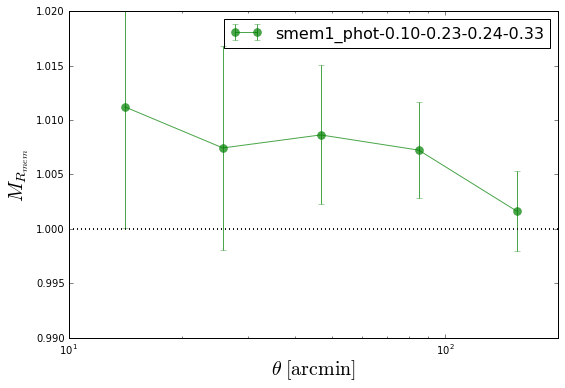

In [96]:
# a. discrete split, suhurd mark correlation; this is to recover Suhurd's numbers; Rmem_type=1 is Surhud's M16.
test_angular_mark_discrete_ipmu(zrange0, zrange1, Rmem_types=[1], figext=figext)

In [111]:
def test_angular_mark_discrete_ipmu_modified(zrange0, zrange1, Rmem_types=[1], ymin=0.99, ymax=1.02, figext=None):
    """ discrete and surhud's correlation but with my version of covariance calculation.
    """
    mediancut = 'discrete'
    north_only = True
    z00, z01 = zrange0
    z10, z11 = zrange1
    zstr0 = '-'.join([format(z00, '3.2f'), format(z01, '3.2f')])
    zstr1 = '-'.join([format(z10, '3.2f'), format(z11, '3.2f')])
    myzstrs = [zstr0, zstr1]
    #
    outstr_list = ["smem"+str(Rmem_type)+"_phot" for Rmem_type in Rmem_types]
    zstrs_list = [myzstrs]*len(outstr_list)
    if True:
        chi2rs = []
        # for Rmem_type in [1, 2, 3, 4]:
        for Rmem_type in Rmem_types:
            chi2r = cluster_angular_marked_correlation_ipmu_modified(Rmem_type, zrange0,
                    zrange1, nabin=5, amin_arcmin=10, amax_arcmin=200,
                    use_res=False, use_spec=False,
                    north_only=north_only,
                    mediancut=mediancut)
            chi2rs.append(chi2r)
        print "reduced chi-square/dof:", chi2rs
    figout = 'plots/angular_mark_suhurd_ipmu'
    comp_angular_mark(zstrs_list, outstr_list, mediancut=mediancut,
            ymin=ymin, ymax=ymax,
            use_band=False, figout=figout, figext=figext, set_ipmu=True)


reading from /Users/ying/Data/redmapper/redmapper_dr8_public_v5.10_smem_discrete1.h5
loading the mesh from file measurements/jk_mesh_mgs100.p
[[ 1.00000004  0.47700355  0.51931483  0.50263783  0.56434799]
 [ 0.47700355  1.00011608  0.64068637  0.6433264   0.66263688]
 [ 0.51931483  0.64068637  1.00018775  0.72754865  0.68201816]
 [ 0.50263783  0.6433264   0.72754865  1.00085686  0.85154279]
 [ 0.56434799  0.66263688  0.68201816  0.85154279  1.00024808]]
pickling results to smem_output/smem1_photwthetamark_discrete_z0.10-0.23-0.24-0.33_ipmu.p
reduced chi-square/dof: [1.5238257976145198]
smem_output/smem1_photwthetamark_discrete_z0.10-0.23-0.24-0.33_ipmu.p


/Users/ying/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:212: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/ying/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:215: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/ying/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:220: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/ying/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:221: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


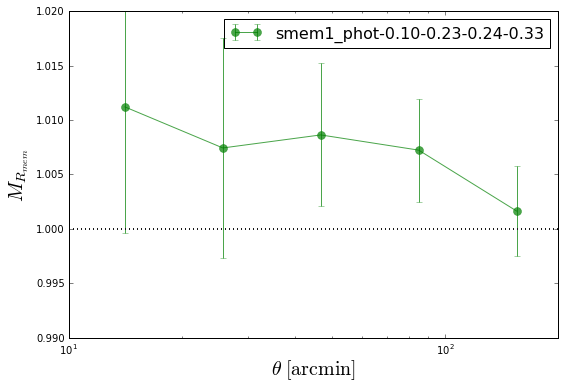

In [98]:
# b. discrete split, modified suhurd mark correlation, which should agree with mine.
# the chi2/dof increases from 1.29 to 1.52 for Suhurd's M16 Rmem.
test_angular_mark_discrete_ipmu_modified(zrange0, zrange1, Rmem_types=[1], figext=figext)

In [112]:
def test_angular_mark_discrete_cmu(zrange0, zrange1, Rmem_types=[1], ymin=0.99, ymax=1.02, figext=None):
    """ discrete and my correlation function
    """
    mediancut = 'discrete'
    north_only = True
    z00, z01 = zrange0
    z10, z11 = zrange1
    zstr0 = '-'.join([format(z00, '3.2f'), format(z01, '3.2f')])
    zstr1 = '-'.join([format(z10, '3.2f'), format(z11, '3.2f')])
    myzstrs = [zstr0, zstr1]
    outstr_list = ["smem"+str(Rmem_type)+"_phot" for Rmem_type in Rmem_types]
    zstrs_list = [myzstrs]*len(outstr_list)
    if True:
        chi2rs = []
        # for Rmem_type in [1, 2, 3, 4]:
        for Rmem_type in Rmem_types:
            chi2r=cluster_angular_marked_correlation_cmu(Rmem_type, zrange0, zrange1,
                    nabin=6, zb1=0.50, use_res=False, use_spec=False,
                    north_only=north_only,
                    mediancut=mediancut)
            chi2rs.append(chi2r)
        print "reduced chi-square/dof:", chi2rs
    figout = 'plots/angular_mark_discrete_cmu'
    comp_angular_mark(zstrs_list, outstr_list, mediancut=mediancut,
            ymin=ymin, ymax=ymax,
            use_band=False, figout=figout, figext=figext)

reading from /Users/ying/Data/redmapper/redmapper_dr8_public_v5.10_smem_discrete1.h5
loading the mesh from file measurements/jk_mesh_mgs100.p
loading the mesh from file measurements/jk_mesh_mgs100.p
loading 2177 points in 3-D to libkd tree
uniform weights
points have marks
finish building 1 libkd tree
loading 3397 points in 3-D to libkd tree
uniform weights
points have marks
finish building 1 libkd tree
cross-correlation
DD counting
Do matching all at once
paircounting between two trees:
primary with 1 subtrees
libkd tree of 2177 points in 3-D
secondary with 1 subtrees
libkd tree of 3397 points in 3-D
ntrees are both 1, use old matching method
crossing
found 35866 pairs within radius of    0.05875
assigning distances into bins
0 of 5
1 of 5
2 of 5
3 of 5
4 of 5
WW counting
finish freeing 1 libkd tree
finish freeing 1 libkd tree
jackkniving
extracting jackknife subsample 0
extracting jackknife subsample 1
extracting jackknife subsample 2
extracting jackknife subsample 3
extracting jackk

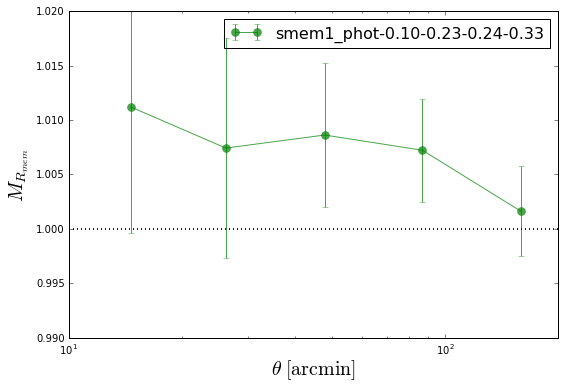

In [100]:
# c. discrete split, my mark correlation
# the chi2/dof is 1.52, consistent with the modified version of Suhurd's code.
test_angular_mark_discrete_cmu(zrange0, zrange1, Rmem_types=[1], figext=figext)

In [113]:
def test_angular_mark_spline_cmu(zrange0, zrange1, Rmem_types=[1], ymin=0.99, ymax=1.02, figext=None):
    """ spline and my correlation
    """
    mediancut = 'spline'
    north_only = True
    z00, z01 = zrange0
    z10, z11 = zrange1
    zstr0 = '-'.join([format(z00, '3.2f'), format(z01, '3.2f')])
    zstr1 = '-'.join([format(z10, '3.2f'), format(z11, '3.2f')])
    myzstrs = [zstr0, zstr1]
    #
    outstr_list = ["smem"+str(Rmem_type)+"_phot" for Rmem_type in Rmem_types]
    zstrs_list = [myzstrs]*len(outstr_list)
    if True:
        chi2rs = []
        # for Rmem_type in [1, 2, 3, 4]:
        for Rmem_type in Rmem_types:
            chi2r=cluster_angular_marked_correlation_cmu(Rmem_type, zrange0, zrange1,
                    nabin=6, zb1=0.50, use_res=False, use_spec=False,
                    north_only=north_only,
                    mediancut=mediancut)
            chi2rs.append(chi2r)
        print "reduced chi-square/dof:", chi2rs
    figout = 'plots/angular_mark_spline_cmu'
    comp_angular_mark(zstrs_list, outstr_list, mediancut=mediancut,
            ymin=ymin, ymax=ymax,
            use_band=False, figout=figout, figext=figext)

reading from /Users/ying/Data/redmapper/redmapper_dr8_public_v5.10_smem_spline1.h5
loading the mesh from file measurements/jk_mesh_mgs100.p
loading the mesh from file measurements/jk_mesh_mgs100.p
loading 2177 points in 3-D to libkd tree
uniform weights
points have marks
finish building 1 libkd tree
loading 3397 points in 3-D to libkd tree
uniform weights
points have marks
finish building 1 libkd tree
cross-correlation
DD counting
Do matching all at once
paircounting between two trees:
primary with 1 subtrees
libkd tree of 2177 points in 3-D
secondary with 1 subtrees
libkd tree of 3397 points in 3-D
ntrees are both 1, use old matching method
crossing
found 35866 pairs within radius of    0.05875
assigning distances into bins
0 of 5
1 of 5
2 of 5
3 of 5
4 of 5
WW counting
finish freeing 1 libkd tree
finish freeing 1 libkd tree
jackkniving
extracting jackknife subsample 0
extracting jackknife subsample 1
extracting jackknife subsample 2
extracting jackknife subsample 3
extracting jackkni

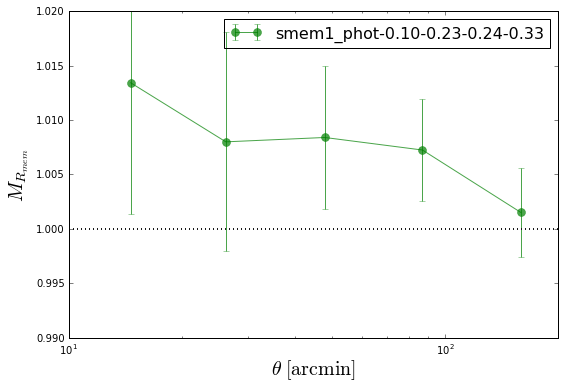

In [102]:
# d. spline split, my mark correlation; this is my default calculation.
# chi2/dof changes to 1.75, still consistent with Surhud's 1.52.
test_angular_mark_spline_cmu(zrange0, zrange1, Rmem_types=[1], figext=figext)

In [114]:
def test_pseudoproj_mark_discrete_ipmu_modified(zrange0, zrange1, Rmem_types=[1], ymin=0.99, ymax=1.02, figext=None):
    """ pseduo projected mark correlation using suhurd's code.
    """
    mediancut = 'discrete'
    north_only = True
    z00, z01 = zrange0
    z10, z11 = zrange1
    zstr0 = '-'.join([format(z00, '3.2f'), format(z01, '3.2f')])
    zstr1 = '-'.join([format(z10, '3.2f'), format(z11, '3.2f')])
    myzstrs = [zstr0, zstr1]
    #
    outstr_list = ["smem"+str(Rmem_type)+"_phot_pproj" for Rmem_type in Rmem_types]
    zstrs_list = [myzstrs]*len(outstr_list)
    if True:
        chi2rs = []
        # for Rmem_type in [1, 2, 3, 4]:
        for Rmem_type in Rmem_types:
            chi2r = cluster_angular_marked_correlation_ipmu_modified(Rmem_type, zrange0,
                    zrange1, nabin=5, amin_arcmin=10, amax_arcmin=200,
                    use_res=False, use_spec=False,
                    north_only=north_only,
                    angular=False,
                    mediancut=mediancut)
            chi2rs.append(chi2r)
        print "reduced chi-square/dof:", chi2rs
    figout = 'plots/pproj_mark_suhurd_ipmu'
    comp_angular_mark(zstrs_list, outstr_list, mediancut=mediancut,
            ymin=ymin, ymax=ymax,
            use_band=False, figout=figout, figext=figext, set_ipmu=True)

reading from /Users/ying/Data/redmapper/redmapper_dr8_public_v5.10_smem_discrete1.h5
0.854008553846 38.1510381143
loading the mesh from file measurements/jk_mesh_mgs100.p
[[ 1.00084141  0.30179218  0.37566943  0.3536025   0.33137833]
 [ 0.30179218  1.00000138  0.63385579  0.69371775  0.70280346]
 [ 0.37566943  0.63385579  1.00019141  0.7478089   0.75217641]
 [ 0.3536025   0.69371775  0.7478089   1.00040122  0.85619408]
 [ 0.33137833  0.70280346  0.75217641  0.85619408  1.00011503]]
pickling results to smem_output/smem1_phot_pprojwthetamark_discrete_z0.10-0.23-0.24-0.33_ipmu.p
reduced chi-square/dof: [0.71150037438541636]
smem_output/smem1_phot_pprojwthetamark_discrete_z0.10-0.23-0.24-0.33_ipmu.p


/Users/ying/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:212: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/ying/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:215: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/ying/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:220: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/ying/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:221: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


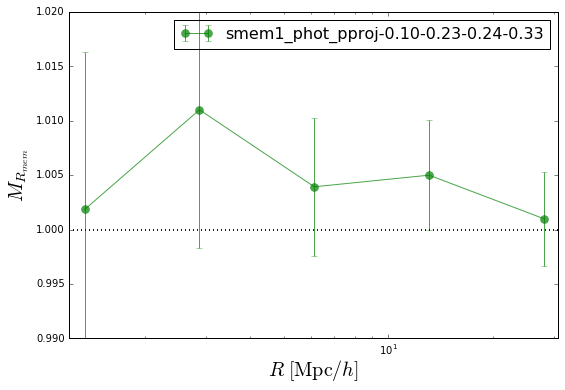

In [127]:
# this is trying the pseudo projected marked correlation --- signal for projection effect is expected to be diluted
# chi2/dof decreases by half, from 1.52 to 0.71
test_pseudoproj_mark_discrete_ipmu_modified(zrange0, zrange1, Rmem_types=[1], figext=figext)

In [128]:
# now let's swtich to higher redshift clusters; comparing M16 (type=1) and Zu (type=4).
zrange0 = [0.30, 0.33]; zrange1 = [0.34, 0.49]

reading from /Users/ying/Data/redmapper/redmapper_dr8_public_v5.10_smem_discrete1.h5
loading the mesh from file measurements/jk_mesh_mgs100.p
[[ 1.00025448  0.35346958  0.32908912  0.43719924  0.43798564]
 [ 0.35346958  1.0000002   0.6590287   0.60485095  0.61417046]
 [ 0.32908912  0.6590287   1.00023131  0.70975753  0.72221197]
 [ 0.43719924  0.60485095  0.70975753  1.00199382  0.8762085 ]
 [ 0.43798564  0.61417046  0.72221197  0.8762085   1.00027624]]
pickling results to smem_output/smem1_photwthetamark_discrete_z0.30-0.33-0.34-0.49_ipmu.p
reading from /Users/ying/Data/redmapper/redmapper_dr8_public_v5.10_smem_discrete4.h5
loading the mesh from file measurements/jk_mesh_mgs100.p
[[ 1.00010569  0.21309977  0.29611536  0.44853073  0.1615932 ]
 [ 0.21309977  1.00037069  0.37289466  0.27096048  0.31262036]
 [ 0.29611536  0.37289466  1.00004592  0.68346574  0.68373688]
 [ 0.44853073  0.27096048  0.68346574  1.00054198  0.80346507]
 [ 0.1615932   0.31262036  0.68373688  0.80346507  1.00033

/Users/ying/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:212: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/ying/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:215: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/ying/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:220: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/ying/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:221: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


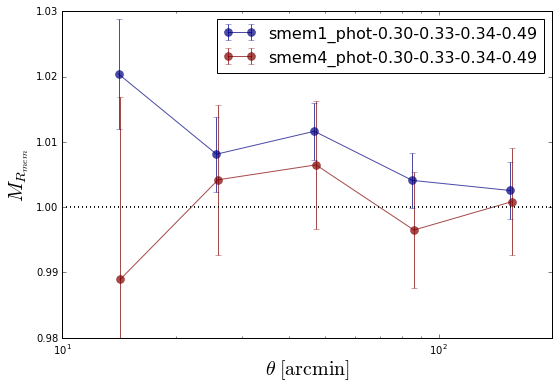

In [129]:
# b. discrete split, modified suhurd mark correlation, which should agree with mine.
# M16: chi2/dof is 4.1 -> significantly deviates from unity.
# Zu: chi2/dof is 0.48, consistent with unity.
test_angular_mark_discrete_ipmu_modified(zrange0, zrange1, Rmem_types=[1, 4], ymin=0.98, ymax=1.03, figext=figext)

reading from /Users/ying/Data/redmapper/redmapper_dr8_public_v5.10_smem_spline1.h5
loading the mesh from file measurements/jk_mesh_mgs100.p
loading the mesh from file measurements/jk_mesh_mgs100.p
loading 1281 points in 3-D to libkd tree
uniform weights
points have marks
finish building 1 libkd tree
loading 8981 points in 3-D to libkd tree
uniform weights
points have marks
finish building 1 libkd tree
cross-correlation
DD counting
Do matching all at once
paircounting between two trees:
primary with 1 subtrees
libkd tree of 1281 points in 3-D
secondary with 1 subtrees
libkd tree of 8981 points in 3-D
ntrees are both 1, use old matching method
crossing
found 57879 pairs within radius of    0.05875
assigning distances into bins
0 of 5
1 of 5
2 of 5
3 of 5
4 of 5
WW counting
finish freeing 1 libkd tree
finish freeing 1 libkd tree
jackkniving
extracting jackknife subsample 0
extracting jackknife subsample 1
extracting jackknife subsample 2
extracting jackknife subsample 3
extracting jackkni

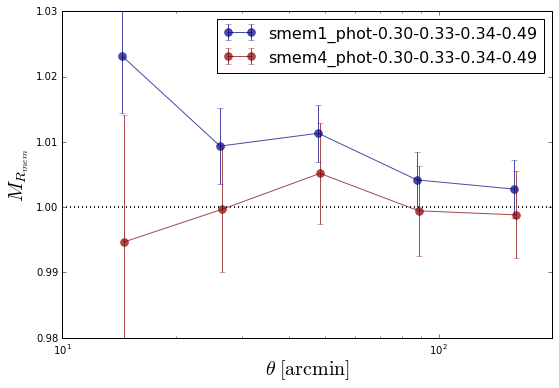

In [122]:
# d. spline split, my mark correlation; this is my default calculation.
# M16: my version gives chi2/dof of 4.3, consistent with Suhurd's discrete normalization.
# Zu: chi2/dof is 0.36
test_angular_mark_spline_cmu(zrange0, zrange1, Rmem_types=[1, 4], ymin=0.98, ymax=1.03, figext=figext)

reading from /Users/ying/Data/redmapper/redmapper_dr8_public_v5.10_smem_discrete1.h5
2.44824442059 53.4743957903
loading the mesh from file measurements/jk_mesh_mgs100.p
[[ 1.00027638  0.343758    0.34047918  0.46581409  0.4519018 ]
 [ 0.343758    1.00002678  0.6167892   0.59711255  0.60484744]
 [ 0.34047918  0.6167892   1.00038256  0.7045314   0.70576497]
 [ 0.46581409  0.59711255  0.7045314   1.00177687  0.88906893]
 [ 0.4519018   0.60484744  0.70576497  0.88906893  1.00018026]]
pickling results to smem_output/smem1_phot_pprojwthetamark_discrete_z0.30-0.33-0.34-0.49_ipmu.p
reading from /Users/ying/Data/redmapper/redmapper_dr8_public_v5.10_smem_discrete4.h5
2.44824442059 53.4743957903
loading the mesh from file measurements/jk_mesh_mgs100.p
[[ 1.00006685  0.19881815  0.27739387  0.37929874  0.16410661]
 [ 0.19881815  1.00070978  0.370888    0.24582656  0.33199565]
 [ 0.27739387  0.370888    1.00006717  0.72321628  0.72373113]
 [ 0.37929874  0.24582656  0.72321628  1.00036768  0.813533

/Users/ying/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:212: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/ying/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:215: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/ying/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:220: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/ying/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:221: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


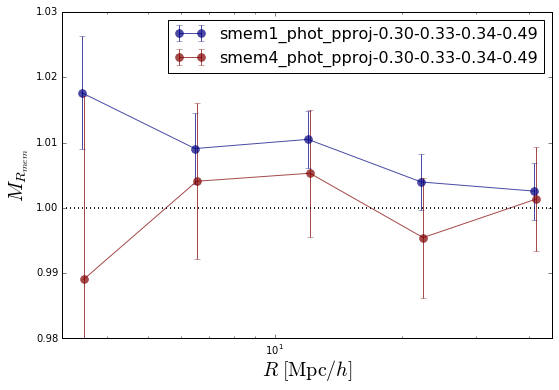

In [130]:
# this is trying the pseudo projected marked correlation --- signal for projection effect is expected to be diluted
# M16: chi2/dof decreases from 4.1 to 2.99, but still significant.
# Zu: chi2/dof is 0.57
test_pseudoproj_mark_discrete_ipmu_modified(zrange0, zrange1, Rmem_types=[1, 4], ymin=0.98, ymax=1.03, figext=figext)